<a href="https://colab.research.google.com/github/aditidagar/ocular_disease_recog/blob/Adding-VGG16-model-Jupiter-files/MODEL/InceptionResNetV2_full_model_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/amd/')
isConcat = False

Mounted at /amd/



Note:  
* edit the path to the dataset depending wehere it was saved. Aslo vgg16_weights_tf_dim_ordering_tf_kernels.h5 is avalible in the repo or you could download it by yourself.

*  vgg16_weights_tf_dim_ordering_tf_kernels.h5 should be used if it is impossible to get the weights in defining the keras.VGG16 model or for manually defined model.



In [ ]:
if isConcat:
    !cp /amd/My\ Drive/CSC490Data/ODIR-5K_aug_contrast_concat.zip /content/
    !unzip ODIR-5K_aug_contrast_concat.zip
else:
    !cp /amd/My\ Drive/CSC490Data/ODIR-5K_aug_contrast_NOFUSION.zip /content/
    !unzip ODIR-5K_aug_contrast_NOFUSION.zip 
    # !cp /amd/My\ Drive/CSC490Data/ODIR-5K_aug_contrast_SUM.zip /content/
    # !unzip ODIR-5K_aug_contrast_SUM.zip

Most of the preparation work is taken from the Grzegors model.

Grzegorz model  https://github.com/GrzegorzMeller/AlgorithmsForMassiveData


In [4]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_WIDTH = 250
if isConcat:
    IMG_WIDTH = 500
IMG_HEIGHT= 250
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [5]:
tf.random.set_seed(10) 
resampled1_ds =  tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [6]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0, 0, 0, 0, 0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'D':
        l[1] = 1
      elif e == 'G':
        l[2] = 1
      elif e == 'C':
        l[3] = 1
      elif e == 'A':
        l[4] = 1
      elif e == 'H':
        l[5] = 1
      elif e == 'M':
        l[6] = 1
      elif e == 'O':
        l[7] = 1

  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.adjust_contrast(img, 2)
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [7]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [19]:
tf.data.experimental.cardinality(resampled_named_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=12942>

In [21]:
tf.data.experimental.cardinality(test_named_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=1969>

(250, 250, 3)
label:  G [0 0 1 0 0 0 0 0]
(250, 250, 3)
label:  D [0 1 0 0 0 0 0 0]
(250, 250, 3)
label:  N [1 0 0 0 0 0 0 0]
(250, 250, 3)
label:  C [0 0 0 1 0 0 0 0]
(250, 250, 3)
label:  D [0 1 0 0 0 0 0 0]
(250, 250, 3)
label:  M [0 0 0 0 0 0 1 0]


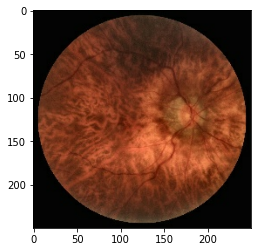

In [8]:
#  Might need to 
for image, label in resampled_named_ds.take(6):
  print(image.shape)
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [9]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
  #image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  #ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [10]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=1000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

[0 0 0 0 0 0 0 1]


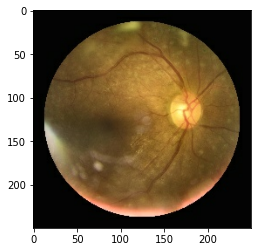

In [11]:
for example in final_train_ds.take(1):
  image, label = example
  break
im, lab = image[13], label[13]
plt.imshow(im.numpy())
print(lab.numpy())

In [27]:
from tensorflow.keras.applications import InceptionResNetV2
# tf.random.set_seed(10) 
inception_res_net_v_2 = InceptionResNetV2(weights="imagenet",
                                          include_top = False,
                                          input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

In [28]:
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Flatten,Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

x = inception_res_net_v_2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# x = Dense(1024, activation='relu')(x)
output_layer = Dense(8, activation='softmax', name='softmax')(x)# sigmoid

model = Model(inputs=inception_res_net_v_2.input, outputs=output_layer)

checkpoint = ModelCheckpoint("inception_res_net_v_2_our_weights_min_augmentation.h5",monitor="val_accuracy",verbose=1, save_best_only=True, save_weights_only=False, period=1)


In [29]:
#  TODO : test with different optimizers such as SGD and Adam with different alphas binary_crossentropy
# tf.random.set_seed(7)  
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True),loss="categorical_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True),loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss="categorical_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 124, 124, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 124, 124, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

In [30]:
if isConcat:
    history = model.fit(final_train_ds,
                        steps_per_epoch = 200, # was 220
                        epochs=40,
                        validation_data=final_test_ds,
                        validation_steps = 30,  # 33
                        verbose=1,
                        callbacks=[checkpoint]
                        )
else :
    history = model.fit(final_train_ds,
                        steps_per_epoch = 400, # todo update this varialbe since there is more data and it requires more steps which is # data / (batch size = 32)
                        epochs=60,
                        validation_data=final_test_ds,
                        validation_steps = 60, # might need to increase this 
                        verbose=1,
                        callbacks=[checkpoint]
                        )

Epoch 1/60
400/400 [==============================] - ETA: 0s - loss: 2.1570 - accuracy: 0.1817 - precision_2: 0.3188 - recall_2: 0.0017
Epoch 00001: val_accuracy improved from -inf to 0.37031, saving model to inception_res_net_v_2_our_weights_min_augmentation.h5
400/400 [==============================] - 202s 451ms/step - loss: 2.1570 - accuracy: 0.1817 - precision_2: 0.3188 - recall_2: 0.0017 - val_loss: 2.0090 - val_accuracy: 0.3703 - val_precision_2: 1.0000 - val_recall_2: 9.7276e-04
Epoch 2/60
400/400 [==============================] - ETA: 0s - loss: 1.9240 - accuracy: 0.3144 - precision_2: 0.8568 - recall_2: 0.0278
Epoch 00002: val_accuracy improved from 0.37031 to 0.38802, saving model to inception_res_net_v_2_our_weights_min_augmentation.h5
400/400 [==============================] - 176s 441ms/step - loss: 1.9240 - accuracy: 0.3144 - precision_2: 0.8568 - recall_2: 0.0278 - val_loss: 1.9149 - val_accuracy: 0.3880 - val_precision_2: 0.8000 - val_recall_2: 0.0214
Epoch 3/60
400/

In [ ]:
!cp /content/inception_res_net_v_2_our_weights_min_augmentation.h5 /amd/My\ Drive/CSC490Data/ 

Results for running model on just enchanced images

In [31]:
model.load_weights("inception_res_net_v_2_our_weights_min_augmentation.h5") # best accuracy is 0.56
model.evaluate(final_test_ds, steps=100)

100/100 [==============================] - 18s 173ms/step - loss: 1.5136 - accuracy: 0.5288 - precision_2: 0.5898 - recall_2: 0.4203


[1.5135879516601562,
 0.5287500023841858,
 0.5897541046142578,
 0.4202686846256256]

Results for running model on just enchanced images + concat

In [ ]:
model.load_weights("inception_res_net_v_2_our_weights_min_augmentation.h5") # best accuracy is 0.56
model.evaluate(final_test_ds, steps=100)

TODO: clean this up

# Clean up: 

In [ ]:
!rm -rf ODIR-5K/

In [ ]:
!rm -f ODIR-5K_aug.zip
!rm -f inception_v3_our_weights_min_augmentation.h5